### Project Overview

## AI-Driven Health & Welfare Enrollment Risk Prediction

## Business Context
Health & Welfare (HCO/H&W) operations handle employee benefit enrollments, elections,
and life events. Missed or delayed enrollments lead to escalations, SLA breaches,
and manual corrections.

Due to confidentiality of real Health & Welfare enrollment data, this project
uses an enterprise HR dataset as a proxy to simulate employee benefit enrollment behavior.

The objective is to:
- Identify employees at high risk of missing benefit enrollment
- Enable proactive outreach by operations teams
- Reduce enrollment escalations and SLA violations

### Imports

In [2]:
## Neccessary Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import pickle

### Data Loading

In [13]:
## Reading the dataset
## Dataset Description

''' This dataset contains employee demographic, job, and engagement attributes
    which are mapped to Health & Welfare enrollment behavior using domain logic.
    python. '''

df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Domain Mapping: HR → Health & Welfare

| HR Attribute | HCO Interpretation |
|-------------|-------------------|
| Age | Medical plan suitability |
| MonthlyIncome | Benefit affordability |
| JobLevel | Plan eligibility tier |
| YearsAtCompany | Enrollment familiarity |
| OverTime | Enrollment risk indicator |
| WorkLifeBalance | Benefits engagement |
| JobSatisfaction | Enrollment attentiveness |


### Data Understanding

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### Exploratory Data Analysis (HCO View)

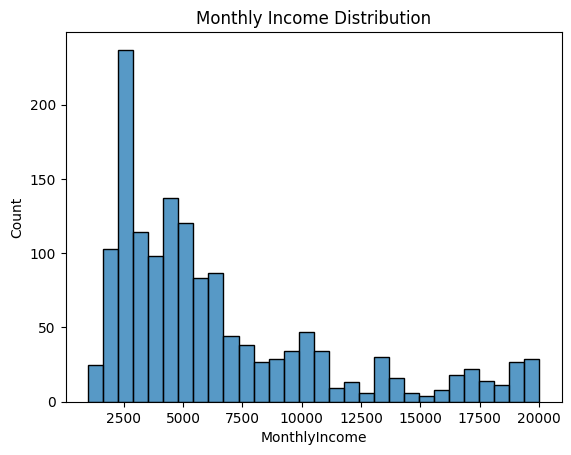

In [10]:
# Income Distribution
plt.figure()
sns.histplot(df["MonthlyIncome"], bins=30)
plt.title("Monthly Income Distribution")
plt.show()

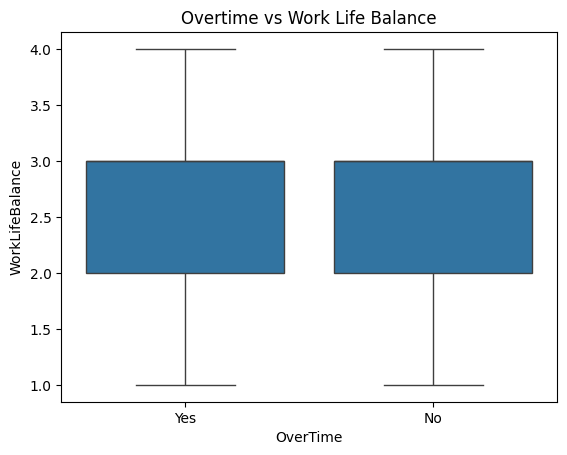

In [11]:
# Overtime vs Worklife Balance
plt.figure()
sns.boxplot(x="OverTime", y="WorkLifeBalance", data=df)
plt.title("Overtime vs Work Life Balance")
plt.show()

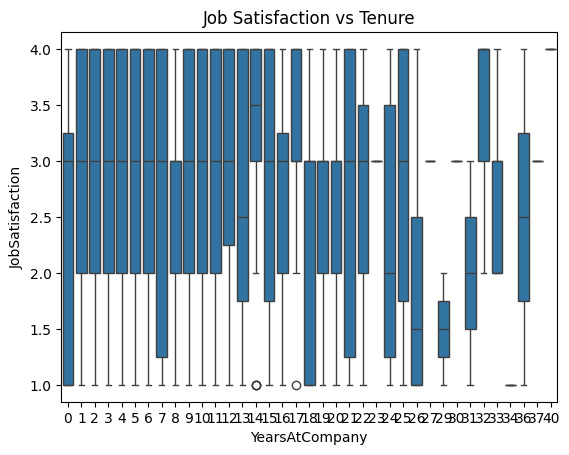

In [12]:
## Job Satisfaction bt tenure
plt.figure()
sns.boxplot(x="YearsAtCompany", y="JobSatisfaction", data=df)
plt.title("Job Satisfaction vs Tenure")
plt.show()

### Feature Engineering

In [14]:
## Income Band
def income_band(income):
    if income < 4000:
        return "Low"
    elif income <= 8000:
        return "Medium"
    else:
        return "High"

df["Income_Band"] = df["MonthlyIncome"].apply(income_band)

In [15]:
## Tenure Bucket
def tenure_bucket(years):
    if years < 1:
        return "New Hire"
    elif years <= 5:
        return "Mid Tenure"
    else:
        return "Long Tenure"

df["Tenure_Bucket"] = df["YearsAtCompany"].apply(tenure_bucket)

In [16]:
## Engagement Score
df["Engagement_Score"] = df["WorkLifeBalance"] + df["JobSatisfaction"]

In [17]:
## Overtime flag
df["Overtime_Flag"] = np.where(df["OverTime"] == "Yes", 1, 0)

### Target Variable Creation

Enrollment Risk Label (Target Variable)

Simulated enrollment risk based on domain assumptions:
- Overtime employees
- Low engagement
- Low tenure

In [18]:
df["Enrollment_Risk"] = np.where(
    (df["OverTime"] == "Yes") &
    (df["Engagement_Score"] <= 4) &
    (df["YearsAtCompany"] < 3),
    1, 0
)

df["Enrollment_Risk"].value_counts()

,count
Enrollment_Risk,
0,1444
1,26


### Encoding

In [19]:
categorical_cols = [
    "Gender", "OverTime", "Income_Band", "Tenure_Bucket", "JobRole"
]

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

### Feature Selection

In [20]:
features = [
    "Age", "MonthlyIncome", "JobLevel", "YearsAtCompany",
    "WorkLifeBalance", "JobSatisfaction",
    "Engagement_Score", "Overtime_Flag",
    "Income_Band", "Tenure_Bucket"
]

X = df[features]
y = df["Enrollment_Risk"]

### Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Model Training (XGBoost)

XGBoost is used due to its performance, explainability,
and enterprise adoption.

In [22]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation and Confusion Matrix

In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00         5

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

ROC-AUC: 1.0


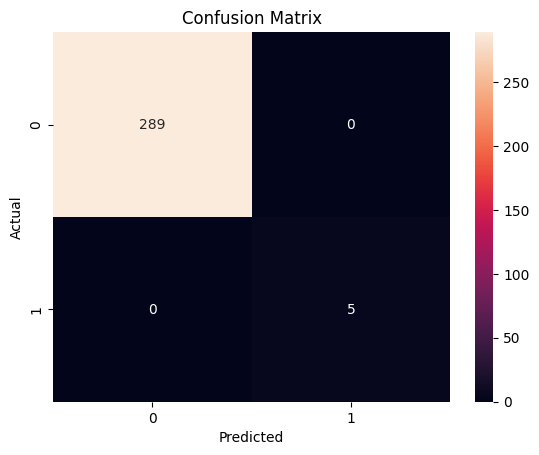

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Business KPI's and saving file.
Business KPIs (Simulated)

- High-risk employees identified proactively
- Reduction in missed enrollments
- Improved SLA adherence
- Reduced manual corrections

Recall is prioritized to minimize missed enrollment cases.

In [25]:
with open("enrollment_risk_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully.")

Model saved successfully.
